<a href="https://colab.research.google.com/github/NikolaZubic/AppliedGameTheoryHomeworkSolutions/blob/main/domaci3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TREĆI DOMAĆI ZADATAK iz predmeta "Primenjena teorija igara" (Applied Game Theory)

Razvoj bota za igranje igre Ajnc (BlackJack) koristeći "Q-learning" pristup.

# Potrebni import-i

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces
import seaborn as sns

# Definisanje Ajnc okruženja koristeći "Open AI Gym" toolkit

In [ ]:
class BlackJackEnvironment(gym.Env):
    # Because of human-friendly output
    metadata = {'render.modes':['human']}
    
    def __init__(self):
      """
      We will define possible number of states with observation_space.
      Player's sum can go from 4 to 32: Now when the sum is 22, and the player chooses to hit, he may get a card with value 10, resulting in a sum of 32, and thus loosing the game.
      Dealer's card can be from 1 to 10 and we have 2 actions.
      Total number of states: 29 * 10 * 2 = 580
      Total number of actions = 2 = len( {"HIT", "STAND"} )
      """
      self.observation_space = spaces.Discrete(580)
      self.action_space = spaces.Discrete(2)
      self.step_count = 0 # at the beginning of the game we have 0 actions taken

    def check_usable_ace(self,hand):
        """
        If someone has an usable ace, we will replace that ace (1) with 11.

        :param hand: player's or dealer's card
        :return: True if we have usable ace, False otherwise
        """
        temp_hand = hand.copy()
        
        # Check if there is ace in hand
        if np.any(temp_hand == 1):
            # If we have any ace then replace it with 11, but if we have more than one ace replace the first one with 11
            temp_hand[np.where(temp_hand == 1)[0][0]] = 11

            # If the sum is less or equal than 21 then we can use it
            if temp_hand.sum() <= 21:
                return True

        return False
        
    def use_ace(self,hand):
        """
        If there is usable ace in function above, then replace 1 with 11.

        :param hand: player's or dealer's hand
        :return: new hand where 1 is replaced with 11
        """
        temp_hand = hand.copy()
        temp_hand[np.where(temp_hand == 1)[0][0]] = 11
        return temp_hand
        
    def reset(self):
        # Resets the environment after one game.
        
        # Initialize player's hand
        self.current_hand = np.random.choice(range(1,11),2)
        
        # Initialize usable Ace to False, since we don't have it at the very beginning
        self.usable_ace = False
  
        self.dealer_stand, self.player_stand = False, False
    
        # Replace usable ace in the player's hand  
        if self.check_usable_ace(self.current_hand):
            self.usable_ace = True
            self.current_hand = self.use_ace(self.current_hand)
        
        # Player's current sum
        self.current_sum = self.current_hand.sum()
        
        # Dealer's hand
        self.dealer_hand = np.random.choice(range(1,11),2)
        
        # Dealer's sum
        self.dealer_sum = self.dealer_hand.sum()
        
        # First element of self.dealer_hand is the current showing card of dealer
        self.dealer_showing_card = self.dealer_hand[0]
        
        # Replace usable ace in the dealer's hand
        if self.check_usable_ace(self.dealer_hand):
            temp_dealer_hand = self.use_ace(self.dealer_hand)
            self.dealer_sum = temp_dealer_hand.sum()
            
    def take_turn(self, current_player):
        """
        Play one turn for the player. This function will be called from step() function, directly depending on the game state.
        We will take new random card, add it to the current_player hand.

        :param player: {"player", "dealer"}
        :return: None
        """
        if current_player == 'dealer':
            # Take new random card
            new_card = np.random.choice(range(1,11))
            
            # Add new card to the current_player hand
            new_dealer_hand = np.array(self.dealer_hand.tolist() +  [new_card])
            
            # Check for usable ace and replace if found
            if self.check_usable_ace(new_dealer_hand):
                new_dealer_hand = self.use_ace(new_dealer_hand)
          
            self.dealer_hand = new_dealer_hand

            # Update his sum
            self.dealer_sum = self.dealer_hand.sum()
                
        if current_player == 'player':            
            new_card = np.random.choice(range(1,11))           
            new_player_hand = np.array(self.current_hand.tolist()+ [new_card])
            
            if self.check_usable_ace(new_player_hand):
                self.usable_ace = True
                new_player_hand = self.use_ace(new_player_hand)
            
            self.current_hand = new_player_hand
            self.current_sum = self.current_hand.sum()
            
    def check_game_status(self, mode = 'normal'):
        """
        Check the current status of the game.
        During the 'normal' we check after each turn whether we got in the terminal state.
        In the 'compare' mode we compare the totals of both players (player vs dealer) in order to pronounce the winner.
        
        :param mode: {'normal', 'compare'}
        :return: dictionary with the winner, whether the game is finished and the reward of the game
        """
        result = {'winner':'',
                 'is_done': False,
                 'reward':0}
        
        if mode == 'normal':
            if self.current_sum > 21:
                result['winner'] = 'dealer'
                result['is_done'] = True
                result['reward'] = -1
            elif self.dealer_sum > 21:
                result['winner'] = 'player'
                result['is_done'] = True
                result['reward'] = 1
            elif self.current_sum == 21:
                result['winner'] = 'player'
                result['is_done'] = True
                result['reward'] = 1
            elif self.dealer_sum == 21:
                result['winner'] = 'dealer'
                result['is_done'] = True
                result['reward'] = -1
        
        elif mode == 'compare':    
            result['is_done'] = True
            diff_21_player = 21 - self.current_sum 
            diff_21_dealer = 21 - self.dealer_sum
            if diff_21_player > diff_21_dealer:
                result['reward'] = -1
                result['winner'] = 'dealer'
            elif diff_21_player < diff_21_dealer:
                result['reward'] = 1
                result['winner'] = 'player'
            else:
                result['reward'] = 0
                result['winner'] = 'draw'
            return result
        
        return result
    
    def step(self,action):
        """
        Performs one action.

        :param action:
        :return: dictionary with the winner, whether the game is finished and the reward of the game
        """
        
        # Increase number of actions that are taken during the game.
        self.step_count += 1
        
        result = {'winner':'',
                 'is_done': False,
                 'reward':0} 
        
        """
        Before taking the first step of the game, we need to ensure that there is no winning condition.
        Check if the initial two cards of the players are 21. If anyone has 21, then that player wins.
        If both players have 21, then the game is DRAW. Otherwise, we will continue with the game.
        """
        if self.step_count == 1:
            if self.check_usable_ace(self.current_hand):
                self.current_hand = self.use_ace(self.current_hand)
            if self.check_usable_ace(self.dealer_hand):
                self.current_hand = self.use_ace(self.dealer_hand)
            
            if self.current_sum == 21 and self.dealer_sum == 21:
                result['is_done'] = True
                result['reward'] = 0
                result['winner'] = 'draw'
                return result
            elif self.current_sum == 21 and self.dealer_sum < 21:
                result['is_done'] = True
                result['reward'] = 1
                result['winner'] = 'player'
                return result
            elif self.dealer_sum == 21 and self.current_sum < 21:
                result['is_done'] = True
                result['reward'] = -1
                result['winner'] = 'dealer'
                return result
            
            if self.dealer_sum >= 17:
                self.dealer_stand = True
        
        # action = 0 means "HIT"
        if action == 0:     
            self.take_turn('player')
            result = self.check_game_status()
            if result['is_done'] == True:
                return result
        
        # action = 1 means "STAND"
        if action == 1:
            if self.dealer_stand == True:
                  return self.check_game_status(mode = 'compare')
                
            """
            If the dealer hasn't stand, he will hit unless his sum is greater than or equal to 17.
            After that, he will stand.
            """
            while self.dealer_sum < 17:
                self.take_turn('dealer')
                result = self.check_game_status()
                # After dealer stands, check the game status.
                if result['is_done'] == True:
                    return result

            # If the game hasn't finished yet, we set dealer_stand to True, so the player will either HIT or STAND            
            self.dealer_stand = True
                      
        return result
        
    def get_current_state(self):
        """
        Get current state which is comprised of current player's sum, dealer's showing card and usable ace presence.
        
        :return: return current state variables
        """
        current_state = {}
        
        current_state['current_sum'] = self.current_sum
        current_state['dealer_showing_card'] = self.dealer_showing_card
        current_state['usable_ace'] = self.usable_ace
        
        return current_state
    
    
    def render(self):
        
        print("OBSERVABLE STATES")
        print("Current player's sum: {}".format(self.current_sum))
        print("Dealer's showing card: {}".format(self.dealer_showing_card))
        print("Player has usable Ace: {}".format(self.usable_ace))
        
        print("INFORMATION ABOUT CARDS AND DEALER'S SUM")
        print("Player's hand: {}".format(self.current_hand))
        print("Dealer's hand: {}".format(self.dealer_hand))
        print("Dealer's sum: {}".format(self.dealer_sum))


# Pomoćne funkcije za Q-learning

In [ ]:
# dictionaries used for converting the state values to indexes in the Q table
current_sum_to_index = dict(zip(np.arange(4,33),np.arange(29)))  
dealer_showing_card_to_index = dict(zip(np.arange(1,11),np.arange(10)))
usable_ace_index = dict(zip([False,True],[0,1]))
action_index = dict(zip(['HIT','STAND'],[0,1]))

def get_state_q_indices(current_state):
    """
    Get indexes of Q table for any given state.

    :param current_state: comprised of current player's sum, dealer's showing card and usable ace presence.
    :return: get table indexes for a state
    """
    current_sum_idx = current_sum_to_index[current_state['current_sum']]
    dealer_showing_card_idx = dealer_showing_card_to_index[current_state['dealer_showing_card']]
    usable_ace_idx = usable_ace_index[current_state['usable_ace']]
    
    return [current_sum_idx,dealer_showing_card_idx,usable_ace_idx]

def get_max_action(Q_sa, current_state):
    """
    Get the action with the max Q-value for the given current state and the Q table.
    
    :param Q_sa: given Q table
    :param current_state: current state
    :return: best action for given state and Q table
    """
    state_q_idxs = get_state_q_indices(current_state)
    action = Q_sa[state_q_idxs[0],state_q_idxs[1],state_q_idxs[2],:].argmax()
    
    return action

def get_q_value(Q_sa, state, action):
    """
    Get Q(s,a) value for state and action in certain Q table.
    
    :param Q_sa: given Q table
    :param state: given state
    :param action: given action
    :return: Q(s, a)
    """
    state_q_idxs = get_state_q_indices(state)
    q_value = Q_sa[state_q_idxs[0],state_q_idxs[1],state_q_idxs[2],action]

    return q_value


# Q-learning

Inicijalizacija Q tabele.

In [ ]:
"""
Player's current sum is ranging from 4 to 32 => 32 - 4 + 1 = 29
Dealer's showing card can be one from the following set {1, 2, 3, 4, 5, 6, 7, 8, 9, 10} => 10 values
Ace can be usable or not => 2
Actions are from the following set {"HIT", "STAND"} => 2
"""
Q = np.zeros((29,10,2,2))

Proces treniranja.

In [ ]:
episode_count = 0
total_episodes = 2000000

# Discounting factor
gamma = 0.9             

# Used for filtering q-values, learning rate
LAMBDA = 0.1

# Defined Black Jack Environment
environment = BlackJackEnvironment()

while episode_count < total_episodes:    
    environment.reset()
    
    current_state = environment.get_current_state()
    current_action = get_max_action(Q, current_state)
    
    # Take action
    step_result = environment.step(current_action)
    
    # Get into next state and get the reward
    next_state = environment.get_current_state()
    next_max_action = get_max_action(Q, next_state)
    immediate_reward = step_result['reward']
    
    next_state_q_idxs = get_state_q_indices(next_state)
    
    # Get the q-value for the next state and max action in the next state
    q_max_s_a = get_q_value(Q, next_state, next_max_action)
    
    td_target = immediate_reward + gamma * q_max_s_a
    
    # Get the q-value for the current state and action
    q_current_s_a = get_q_value(Q, current_state, current_action)
    
    td_error = td_target - q_current_s_a
    
    state_q_idxs = get_state_q_indices(current_state)
    
    # Update the current Q(s, a)
    Q[state_q_idxs[0],state_q_idxs[1],state_q_idxs[2],current_action] = q_current_s_a + LAMBDA * td_error

    # get into the next state                                        
    current_state = next_state
    
    if step_result['is_done']:
        episode_count += 1
        
        if episode_count % 100000 == 0:
            print("Episode number: {}".format(episode_count))


Episode number: 100000
Episode number: 200000
Episode number: 300000
Episode number: 400000
Episode number: 500000
Episode number: 600000
Episode number: 700000
Episode number: 800000
Episode number: 900000
Episode number: 1000000
Episode number: 1100000
Episode number: 1200000
Episode number: 1300000
Episode number: 1400000
Episode number: 1500000
Episode number: 1600000
Episode number: 1700000
Episode number: 1800000
Episode number: 1900000
Episode number: 2000000


# Diskusija rezultata

Text(609.9818181818181, 0.5, "Current Player's Sum")

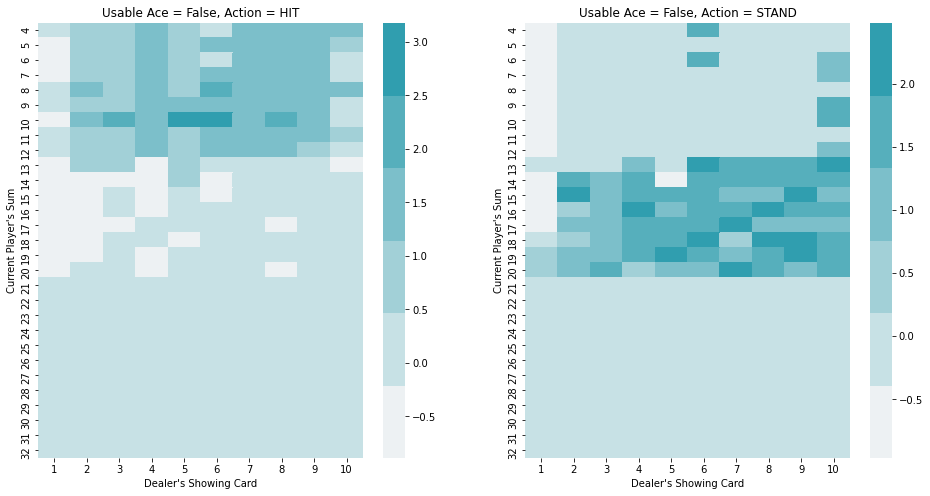

In [ ]:
fig, ax = plt.subplots(ncols= 2,figsize=(16,8)) 
sns.heatmap(Q[:,:,0,0],cmap = sns.light_palette((210, 90, 60), input="husl"), ax = ax[0], 
            xticklabels=np.arange(1,11),yticklabels=np.arange(4,33))
ax[0].set_title("Usable Ace = False, Action = HIT")
ax[0].set_xlabel("Dealer's Showing Card")
ax[0].set_ylabel("Current Player's Sum")


sns.heatmap(Q[:,:,0,1],cmap = sns.light_palette((210, 90, 60), input="husl"), ax = ax[1],
           xticklabels=np.arange(1,11),yticklabels=np.arange(4,33))
ax[1].set_title("Usable Ace = False, Action = STAND")
ax[1].set_xlabel("Dealer's Showing Card")
ax[1].set_ylabel("Current Player's Sum")


Na osnovu gornjih heatmapa možemo uočiti koje je to akcije dobro izvršiti u kojem stanju.

**Zaključak sa lijeve heatmape**: kada je ukupna suma igrača manja od 12, 13 onda je najbolje da se izvršava akcija "HIT".

**Zaključak sa desne heatmape**: Za veće vrijednosti otkrivene karte djelitelja i veće vrijednosti ukupne sume igrača bolje je izvršiti akciju "STAND".

Text(609.9818181818181, 0.5, "Current Player's Sum")

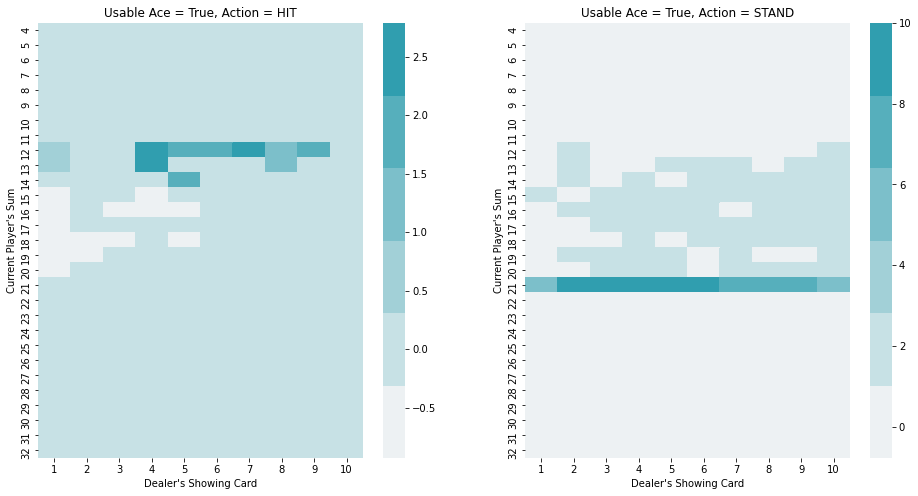

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize=(16,8)) 
sns.heatmap(Q[:,:,1,0],cmap = sns.light_palette((210, 90, 60), input="husl"), ax = ax[0],
           xticklabels=np.arange(1,11),yticklabels=np.arange(4,33))
ax[0].set_title("Usable Ace = True, Action = HIT")
ax[0].set_xlabel("Dealer's Showing Card")
ax[0].set_ylabel("Current Player's Sum")


sns.heatmap(Q[:,:,1,1],cmap = sns.light_palette((210, 90, 60), input="husl"), ax =  ax[1],
           xticklabels=np.arange(1,11),yticklabels=np.arange(4,33))
ax[1].set_title("Usable Ace = True, Action = STAND")
ax[1].set_xlabel("Dealer's Showing Card")
ax[1].set_ylabel("Current Player's Sum")

U slučaju kad imamo iskoristiv kec, broj semplova je znatno manji, tako da paterni Q-vrijednosti nisu baš potpuno jasni, ali može se zaključiti da je najbolje izvršiti akciju **"HIT" u slučajevima kad je suma igrača oko 12**, dok se akcija **"STAND" izvršava u slučaju kada je igra pri kraju po pitanju sume igrača**.

Sada ćemo pogledati naučene politike (za slučaj pohlepne politike, jer želimo da naš igrač uvijek bira onako da najbolje igra).

**Sa crnim blokovima označeno je kada treba izvršiti akciju "HIT"**, a imamo 2 heatmape za slučaj kad nemamo i imamo iskoristiv kec.

Text(51.0, 0.5, "Current Player's Sum")

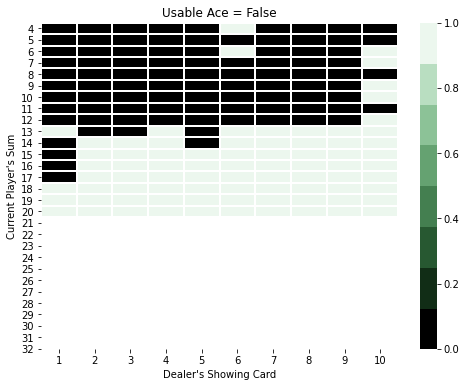

In [ ]:
fig, ax = plt.subplots(ncols= 1,figsize=(8,6)) 
sns.heatmap(np.argmax(Q[:17,:,0,:],axis=2),cmap = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)\
           ,linewidths=1,xticklabels=np.arange(1,11),yticklabels=np.arange(4,33))
ax.set_title("Usable Ace = False")
ax.set_xlabel("Dealer's Showing Card")
ax.set_ylabel("Current Player's Sum")

Text(51.0, 0.5, "Current Player's Sum")

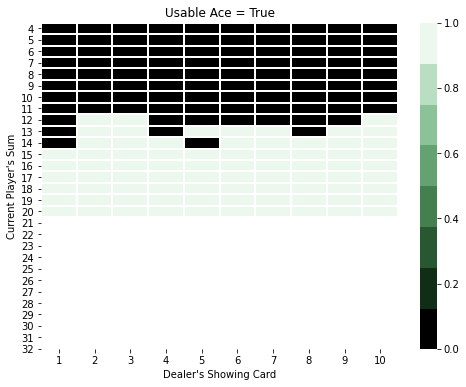

In [ ]:
fig, ax = plt.subplots(ncols= 1,figsize=(8,6)) 
sns.heatmap(np.argmax(Q[:17,:,1,:],axis=2),cmap = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)\
           ,linewidths=1,xticklabels=np.arange(1,11),yticklabels=np.arange(4,33))
ax.set_title("Usable Ace = True")
ax.set_xlabel("Dealer's Showing Card")
ax.set_ylabel("Current Player's Sum")


# Na kraju, nakon 2 miliona iteracija treniranja, testiraćemo algoritam na 10 000 partija.

In [ ]:
player_wins = 0
dealer_wins = 0
NUMBER_OF_GAMES = 10000

for i in range(NUMBER_OF_GAMES):

    environment.reset()

    while True:
        current_state = environment.get_current_state()
        current_action = get_max_action(Q, current_state)

        # Take action
        step_result = environment.step(current_action)
        #environment.render()
        next_state = environment.get_current_state()
        current_state = next_state

        if step_result['is_done']:
            break

    if step_result['winner'] == 'player':
        player_wins += 1
    elif step_result['winner'] == 'dealer':
        dealer_wins += 1

print("Player wins: " + str(player_wins))
print("Dealer wins: " + str(dealer_wins))
print("Player wins percentage = " + str(round(100 * (player_wins / (player_wins + dealer_wins)), 2)) + "%")

Player wins: 3681
Dealer wins: 5706
Player wins percentage = 39.21%
